CODE BLOCK: 1

In [12]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from utils import *
from model import Net
from torchsummary import summary
import torch.nn as nn

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

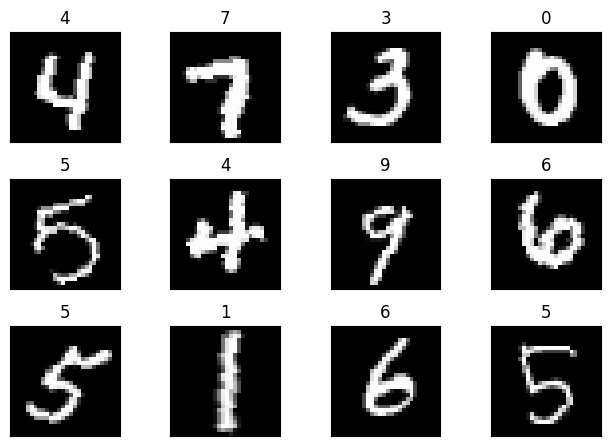

In [6]:
batch_data, batch_label = next(iter(train_loader)) 
plot_batch(batch_data, batch_label)

CODE BLOCK: 7

In [7]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.4002 Batch_id=117 Accuracy=54.75: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0005, Accuracy: 55593/60000 (92.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2546 Batch_id=117 Accuracy=93.86: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0002, Accuracy: 58246/60000 (97.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2326 Batch_id=117 Accuracy=96.29: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0002, Accuracy: 58467/60000 (97.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0317 Batch_id=117 Accuracy=96.97: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0001, Accuracy: 58839/60000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0516 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Test set: Average loss: 0.0001, Accuracy: 59095/60000 (98.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0215 Batch_id=117 Accuracy=97.74: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Test set: Average loss: 0.0001, Accuracy: 59180/60000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0894 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0001, Accuracy: 59302/60000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0822 Batch_id=117 Accuracy=98.18: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0001, Accuracy: 59334/60000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1199 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0001, Accuracy: 59387/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0100 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Test set: Average loss: 0.0001, Accuracy: 59530/60000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0553 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0001, Accuracy: 59442/60000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0563 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0001, Accuracy: 59432/60000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0689 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0001, Accuracy: 59500/60000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0203 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


Test set: Average loss: 0.0000, Accuracy: 59595/60000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0238 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Test set: Average loss: 0.0000, Accuracy: 59596/60000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0189 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


Test set: Average loss: 0.0000, Accuracy: 59724/60000 (99.54%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0277 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0000, Accuracy: 59725/60000 (99.54%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0031 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0000, Accuracy: 59728/60000 (99.55%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0158 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0000, Accuracy: 59732/60000 (99.55%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0582 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0000, Accuracy: 59747/60000 (99.58%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

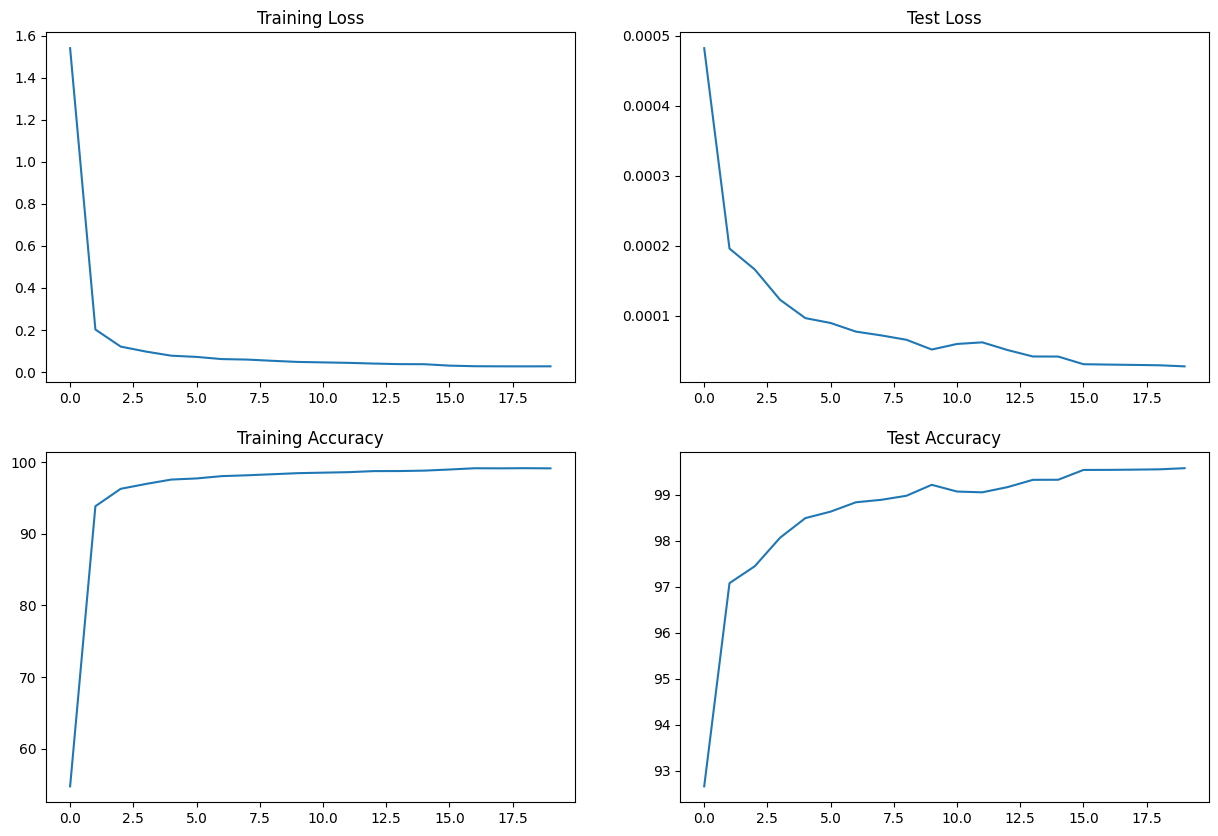

In [14]:
plt_graph(train_losses,test_losses,train_acc,test_acc)